<a href="https://colab.research.google.com/github/sman-1010/ANALYZING-PAINTER-S-INFLUENCES-ON-ARTWORKS-WITH-CNNS/blob/main/Github_CNN_for_Paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)

tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!ls

artists.csv  myntradataset     resized	    v1_100px1e_my_model.h5
images	     picnames	       saved_model  v2_100px10e_my_model.h5
kaggle.json  predictions_list  styles.csv


In [ ]:
!pwd

/content/gdrive/MyDrive/Kaggle


# Reading Inputs

In [ ]:
print(os.listdir("/content/gdrive/MyDrive/Kaggle"))

['artists.csv', 'myntradataset', 'styles.csv', 'kaggle.json', 'images', 'resized', 'saved_model', 'v1_100px1e_my_model.h5', 'v2_100px10e_my_model.h5', 'picnames', 'predictions_list']


In [ ]:
artists = pd.read_csv('/content/gdrive/MyDrive/Kaggle/artists.csv')
artists.shape

(50, 8)

# Reading Inputs

In [ ]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
artists

,id,name,years,genre,nationality,bio,wikipedia,paintings
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
46,46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311
16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
20,20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
32,32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [ ]:
# updated_name = "Albrecht_Dürer".replace("_", " ")
updated_name = "Albrecht_Du╠Иrer"
artists_top.iloc[4, 0] = updated_name

In [ ]:
# Explore images of top artists
images_dir = '/content/gdrive/MyDrive/Kaggle/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/gdrive/MyDrive/Kaggle/images/images/Vincent_van_Gogh
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Edgar_Degas
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Pablo_Picasso
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Pierre-Auguste_Renoir
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Albrecht_Du╠Иrer
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Paul_Gauguin
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Francisco_Goya
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Rembrandt
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Alfred_Sisley
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Titian
Found --> /content/gdrive/MyDrive/Kaggle/images/images/Marc_Chagall


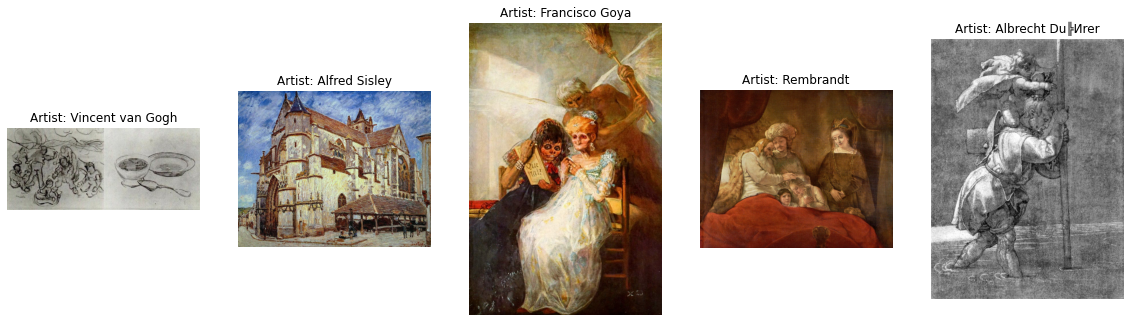

In [ ]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

# Data Augmentation 

In [ ]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


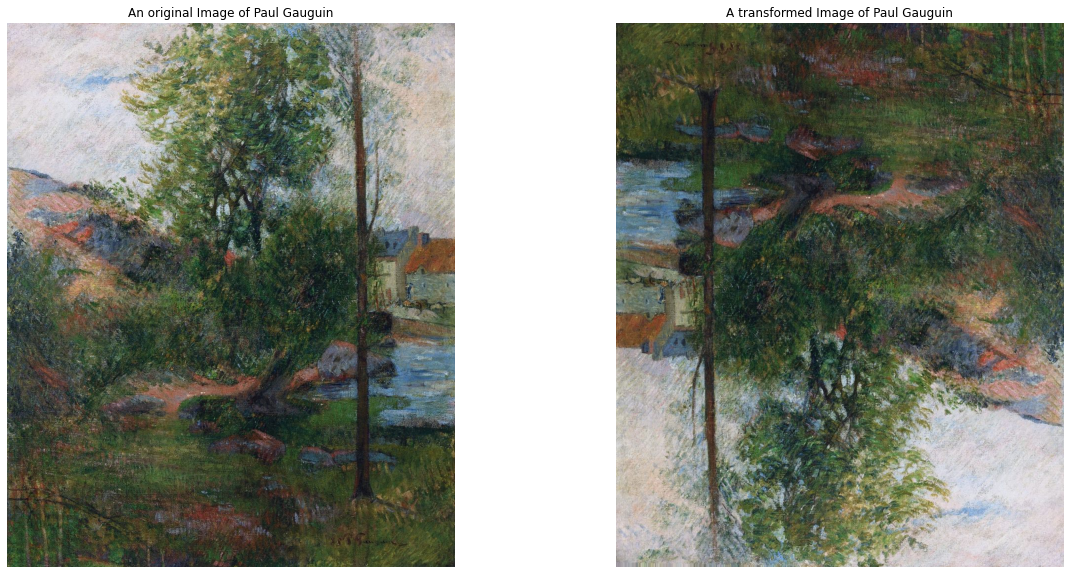

In [ ]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

#Building Model 

In [ ]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
215/215 [==============================] - 226s 940ms/step - loss: 1.5976 - accuracy: 0.4084 - val_loss: 2.9773 - val_accuracy: 0.0767 - lr: 1.0000e-04
Epoch 2/10
215/215 [==============================] - 141s 629ms/step - loss: 1.2206 - accuracy: 0.6324 - val_loss: 4.7206 - val_accuracy: 0.0684 - lr: 1.0000e-04
Epoch 3/10
215/215 [==============================] - 141s 629ms/step - loss: 1.0626 - accuracy: 0.7284 - val_loss: 4.3401 - val_accuracy: 0.0483 - lr: 1.0000e-04
Epoch 4/10
215/215 [==============================] - 142s 635ms/step - loss: 0.9190 - accuracy: 0.7990 - val_loss: 2.6374 - val_accuracy: 0.1851 - lr: 1.0000e-04
Epoch 5/10
215/215 [==============================] - 142s 633ms/step - loss: 0.8454 - accuracy: 0.8206 - val_loss: 1.6504 - val_accuracy: 0.5153 - lr: 1.0000e-04
Epoch 6/10
215/215 [==============================] - 141s 627ms/step - loss: 0.7384 - accuracy: 0.8603 - val_loss: 1.0300 - val_accuracy: 0.7877 - lr: 1.0000e-04
Epoch 7/10
215/215 [==

In [ ]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
215/215 [==============================] - 159s 652ms/step - loss: 0.2612 - accuracy: 0.9726 - val_loss: 0.7511 - val_accuracy: 0.8420 - lr: 1.0000e-04
Epoch 2/10
215/215 [==============================] - 143s 634ms/step - loss: 0.2342 - accuracy: 0.9793 - val_loss: 0.7746 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 3/10
215/215 [==============================] - 139s 618ms/step - loss: 0.2161 - accuracy: 0.9802 - val_loss: 0.7682 - val_accuracy: 0.8219 - lr: 1.0000e-04
Epoch 4/10
215/215 [==============================] - 139s 623ms/step - loss: 0.2049 - accuracy: 0.9775 - val_loss: 0.7388 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 5/10
215/215 [==============================] - 142s 636ms/step - loss: 0.1978 - accuracy: 0.9755 - val_loss: 0.7230 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 6/10
215/215 [==============================] - 141s 626ms/step - loss: 0.1813 - accuracy: 0.9822 - val_loss: 0.7272 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 7/10
215/215 [==

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


216/216 [==============================] - 123s 567ms/step - loss: 0.2180 - accuracy: 0.9884
Prediction accuracy on train data = 0.9883856177330017


In [ ]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


54/54 [==============================] - 31s 565ms/step - loss: 0.6784 - accuracy: 0.8351
Prediction accuracy on CV data = 0.8350877165794373


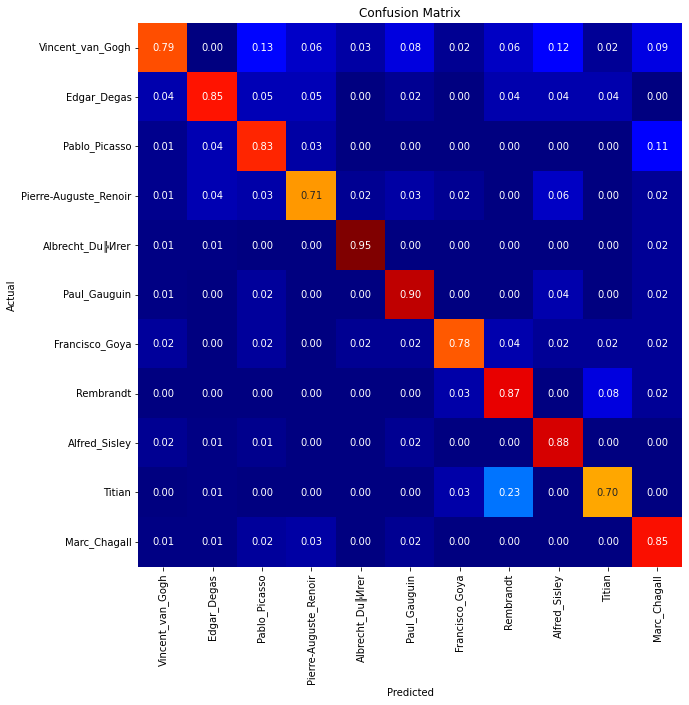

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.87      0.79      0.83       174
          Edgar_Degas       0.88      0.85      0.86       137
        Pablo_Picasso       0.74      0.83      0.78        87
Pierre-Auguste_Renoir       0.81      0.71      0.76        66
     Albrecht_Du╠Иrer       0.94      0.95      0.95        65
         Paul_Gauguin       0.83      0.90      0.87        61
       Francisco_Goya       0.88      0.78      0.83        58
            Rembrandt       0.70      0.87      0.78        52
        Alfred_Sisley       0.76      0.88      0.82        51
               Titian       0.81      0.70      0.75        50
         Marc_Chagall       0.74      0.85      0.79        47

             accuracy                           0.82       848
            macro avg       0.82      0.83      0.82       848
         weighted avg       0.83      0.82      0.82       848



In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

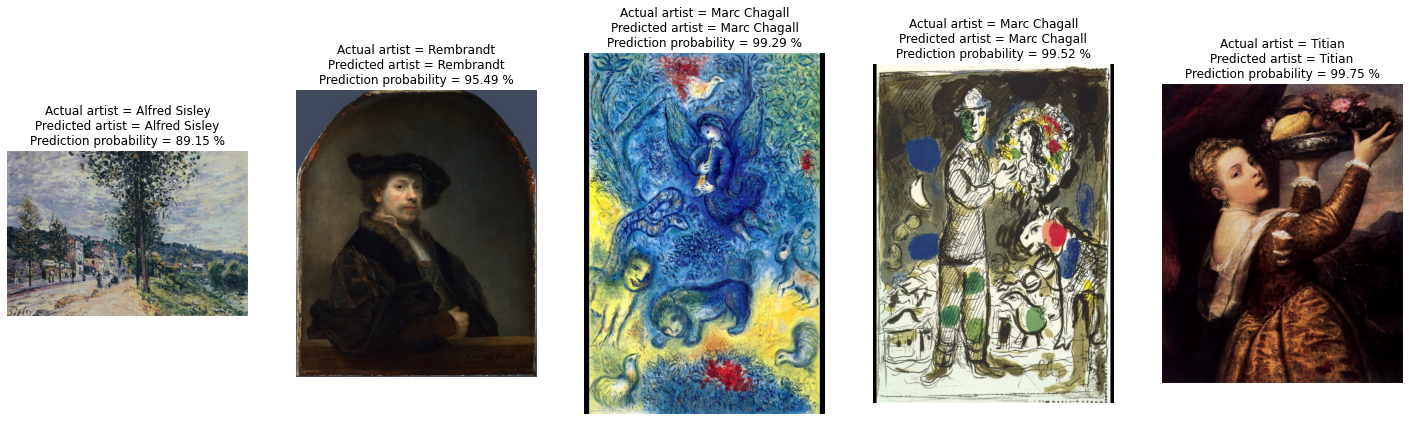

In [ ]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

Predicted artist = Marc Chagall
Prediction probability = 83.06286334991455 %


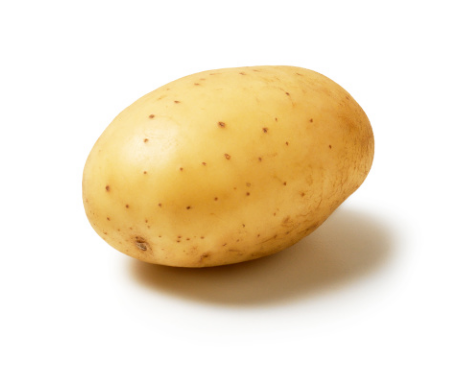

In [ ]:
# Predict from web - this is an image of Titian.
# Replace 'url' with any image of one of the 11 artists above and run this cell.
# url = 'https://www.gpsmycity.com/img/gd/2081.jpg'
url = "https://media.istockphoto.com/photos/single-potato-picture-id176012507?k=20&m=176012507&s=170667a&w=0&h=BNJ7To0ABzgZNd5MbhY242FepT2cb8K7238R63QGKIE="
# url = "https://i.ibb.co/frR7xXK/ship.jpg"


import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

In [ ]:
prediction

array([[0.00244432, 0.00980656, 0.03037144, 0.00579244, 0.01780134,
        0.0221571 , 0.07284884, 0.0016722 , 0.00224632, 0.00423084,
        0.83062863]], dtype=float32)

In [ ]:
labels

{0: 'Vincent_van_Gogh',
 1: 'Edgar_Degas',
 2: 'Pablo_Picasso',
 3: 'Pierre-Auguste_Renoir',
 4: 'Albrecht_Du╠Иrer',
 5: 'Paul_Gauguin',
 6: 'Francisco_Goya',
 7: 'Rembrandt',
 8: 'Alfred_Sisley',
 9: 'Titian',
 10: 'Marc_Chagall'}

In [ ]:
!ls

artists.csv  kaggle.json    resized	 styles.csv
images	     myntradataset  saved_model


In [ ]:
model.save('v3_200px10e_my_model_15feb.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
